##### ссылки на файлы:
- код для API-запросов (*.html): <https://yadi.sk/d/aeTTT0WjtbSHFw>
- презентация (*.pptx): <https://yadi.sk/i/p6aqq9ZzWwj2-w>
- презентация (*.pdf): <https://yadi.sk/i/5Zv_DDq5A1-Z5A>

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objects as go
import plotly.express as px
import numpy as np

## Получение данных

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Данные загрузились успешно

## Предварительная обработка данных

In [3]:
# поиск пропусков
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропусков нет

In [4]:
#поиск дубликатов
rest_data.duplicated(keep=False).sum()

0

Дубликатов нет

In [5]:
#уникальные значения столбца о типе объекта
rest_data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Данные корректные

In [6]:
# уникальные значения стобца о принадлежности к сети заведений
rest_data['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

Информация корректная

In [7]:
# распределение количества посадочных мест
rest_data['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

80 посадочных мест - это не предел, а 1 700 явно слишком много. Часто ли встречаются заведения с большим количеством мест?

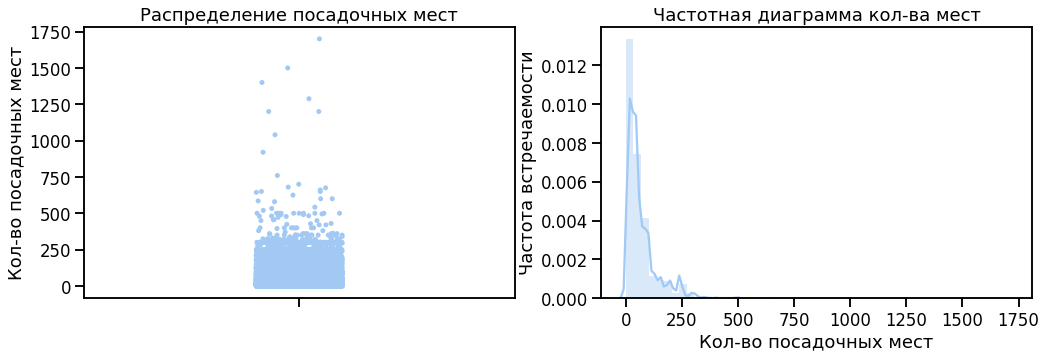

In [8]:
sns.set_palette('pastel')
plt.subplots(figsize=(17,5))
sns.set_context('talk')
plot = sns.stripplot(y = 'number', data = rest_data, ax = plt.subplot(1,2,1))
plt.title('Распределение посадочных мест')
plt.ylabel('Кол-во посадочных мест')
plot = sns.distplot(rest_data['number'],  ax = plt.subplot(1,2,2))
plt.title('Частотная диаграмма кол-ва мест')
plt.ylabel('Частота встречаемости')
plt.xlabel('Кол-во посадочных мест');

Роботы производительнее людей, но проект явно не рассчитан на сверхмассовость, по меньшей мере в первое время. Поэтому следует ограничиться выборкой заведений с количеством посадочных мест до 250.

In [9]:
# кол-во заведений с кол-вом посадочных мест более 250 
print('Процент заведений с количеством посадочных мест более 250: {:.1%}'.format(
    rest_data.query('number > 250')['id'].count() / rest_data.shape[0]))

Процент заведений с количеством посадочных мест более 250: 1.9%


Вероятно, это некие уникальные заведения. Для дальнейшей работы список ограничивается заведениями с количеством посадочых мест 250 и менее.

In [10]:
rest_data_250 = rest_data.query('number < = 250')

## Обработка данных
Из списка заведений требуется выбрать располагающиеся в Москве. Адрес задан строкой в столбце 'address', необходимо выделить город и улицу.

In [11]:
# после изучения данных "вручную" определил следующие фильтры: 
# результат метода str.find по "город Москва" должен быть равен 0
# результат метода str.find по "город Зеленоград" и "Московский" должен быть равен -1  
rest_data_moscow = rest_data_250[
    (rest_data_250['address'].str.find('город Зеленоград') == -1) &
    (rest_data_250['address'].str.find('город Москва') == 0) &
    (rest_data_250['address'].str.find('Московский') == -1)
]

In [12]:
rest_data_moscow['street'] = rest_data_moscow['address'].str.split(pat = ", ", expand = True)[1]

In [13]:
unique_addresses = rest_data_moscow['address'].value_counts().reset_index()
unique_addresses.columns = ['uniq_adress','obj_count']

In [14]:
# записал в отдельный файл уникальные адреса
# unique_addresses.to_csv('uniq_addresses')
# работал с ними в отдельном notebook
# результаты в датасете 'final_addresses.csv'

In [15]:
address_district = pd.read_csv('final_addresses.csv', usecols = ['uniq_adress','district'])
address_district.columns = ['uniq_address','district']
address_district.head()

,uniq_address,district
0,"город Москва, Ходынский бульвар, дом 4",Хорошёвский район
1,"город Москва, Пресненская набережная, дом 2",Пресненский район
2,"город Москва, проспект Мира, дом 211, корпус 2",район Свиблово
3,"город Москва, Кировоградская улица, дом 13А",район Чертаново Центральное
4,"город Москва, площадь Киевского Вокзала, дом 2",район Дорогомилово


In [16]:
# объединение данных о районе с начальным датасетом по уникальному адресу
moscow_rest = rest_data_moscow.merge(
    address_district,
    how = 'left',
    left_on = 'address',
    right_on = 'uniq_address' 
)
del moscow_rest['uniq_address']

In [17]:
moscow_rest.head(3)

,id,object_name,chain,object_type,address,number,street,district
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,Ярославский район
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,Таганский район
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,Таганский район


## Анализ данных
### Cоотношение видов объектов общественного питания

In [18]:
graph_1 = moscow_rest.groupby('object_type')['id'].count().reset_index()
graph_1.columns = ['object_type','number']
colors = [
    'Crimson',
    'DarkOrange',
    'DeepSkyBlue',
    'Green',
    'LightSalmon',
    'MediumOrchid',
    'PaleVioletRed',
    'YellowGreen'
]
fig = go.Figure(data=[go.Pie(labels = graph_1['object_type'], values = graph_1['number'])])
fig.update_traces(
    hoverinfo='label+percent', 
    textinfo='value', 
    textfont_size=15,
    marker=dict(colors=colors, line=dict(color='#000000', width=1))
)
#fig.update_layout(
    #title_text = 'Соотношение видов объектов общепита')
fig.show()

Наиболее распространены кафе - 40 %, столовые и рестораны представлены практически в одинаковых долях - около 15 %, предприятия быстрого обслуживания занимают долю около 13 %, замыкает Топ-5 бары - немногим более 5 %.
### Соотношение сетевых и несетевых заведений

In [19]:
graph_2 = moscow_rest.groupby('chain')['id'].count().reset_index()
graph_2 = graph_2.replace({'да':'сетевые','нет':'несетевые'})
graph_2.columns = ['chain','number']
total = graph_2['number'].sum()
graph_2['ratio'] = graph_2['number'] / total
fig = go.Figure(data = [go.Bar(x = graph_2['chain'], y = graph_2['number'],
                               text = ['{:.1%}'.format(graph_2['ratio'][0]),
                                       '{:.1%}'.format(graph_2['ratio'][1])],
                               textposition = 'inside',
                               textfont = dict(
                                   size = 20,
                                   color = 'red'
                               )
            )
                       ]
               )
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title_text='Сетевые и несетевые заведения', 
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 2000,
        tickformat = 'int',
        tickfont_size=18,
        title = go.layout.yaxis.Title(
            text= 'Кол-во заведений',
            font_size = 26
        )
    ),
    xaxis = dict(
        tickfont_size = 18
    )
)
fig.show()


Несетевых заведений - 80 %, сетевых - 20 %.

### Сетевое распространение

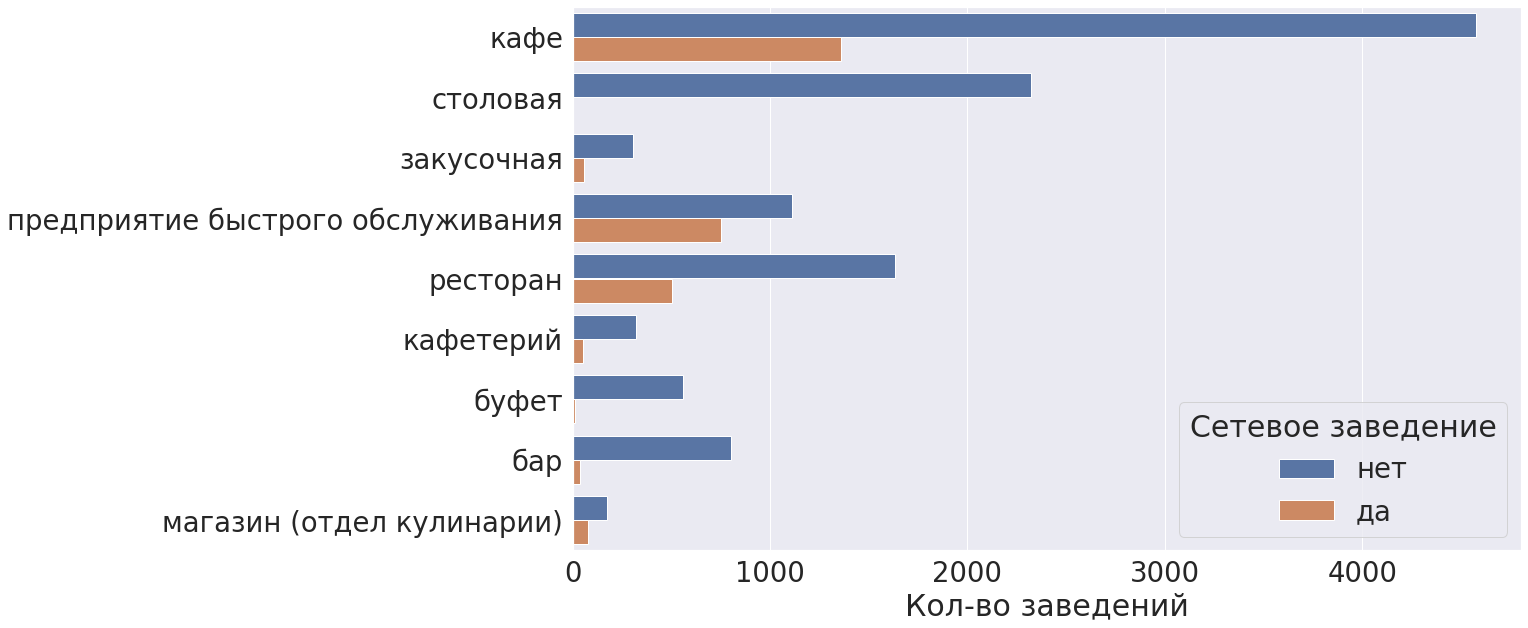

In [20]:
plt.figure(figsize=(17,10))
sns.set(font_scale=2.5)
sns.countplot(y = 'object_type', data = moscow_rest, hue = 'chain')
plt.legend(title = 'Сетевое заведение')
plt.ylabel('')
plt.xlabel('Кол-во заведений');

Сетевое распространение характерно для предприятий быстрого обслуживания, практически 3/4 всех заведений являются сетевыми. Треть ресторанов и более четверти кафе также принадлежат сетям.
### Особенности сетевых заведений

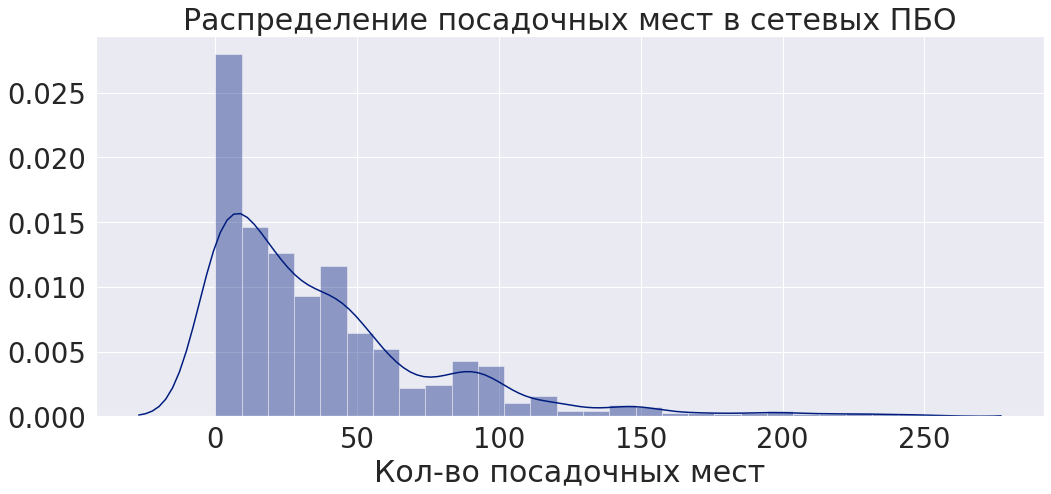

In [21]:
plt.figure(figsize=(17,7))
sns.set(font_scale=2.5)
sns.set_palette('dark')
sns.distplot(moscow_rest[np.logical_and(
    moscow_rest['object_type'] == 'предприятие быстрого обслуживания', 
    moscow_rest['chain'] == 'да')]['number'])
plt.xlabel('Кол-во посадочных мест');
plt.title('Распределение посадочных мест в сетевых ПБО');

In [22]:
moscow_rest[np.logical_and(
    moscow_rest['object_type'] == 'предприятие быстрого обслуживания', 
    moscow_rest['chain'] == 'да')]['number'].describe()

count    752.000000
mean      38.331117
std       41.588667
min        0.000000
25%        8.000000
50%       25.000000
75%       51.250000
max      250.000000
Name: number, dtype: float64

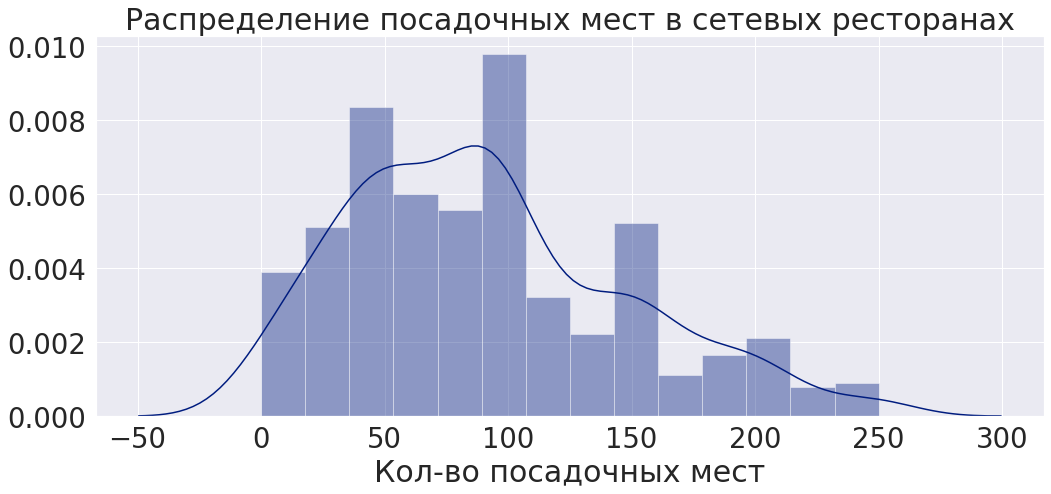

In [23]:
plt.figure(figsize=(17,7))
sns.set(font_scale=2.5)
sns.set_palette('dark')
sns.distplot(moscow_rest[np.logical_and(
    moscow_rest['object_type'] == 'ресторан', 
    moscow_rest['chain'] == 'да')]['number'])
plt.xlabel('Кол-во посадочных мест')
plt.title('Распределение посадочных мест в сетевых ресторанах');

In [24]:
moscow_rest[np.logical_and(
    moscow_rest['object_type'] == 'ресторан', 
    moscow_rest['chain'] == 'да')]['number'].describe()

count    503.00000
mean      91.04175
std       56.54026
min        0.00000
25%       49.50000
50%       86.00000
75%      122.50000
max      250.00000
Name: number, dtype: float64

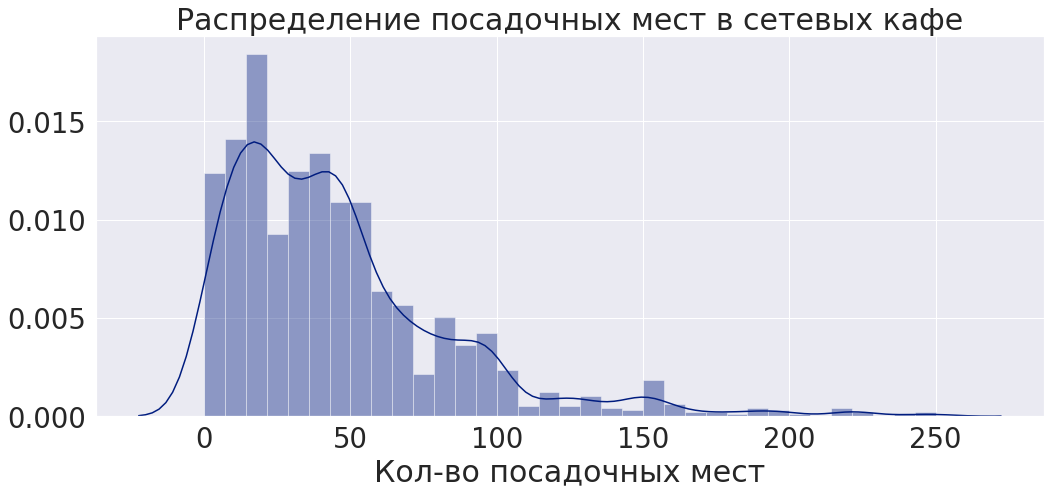

In [25]:
plt.figure(figsize=(17,7))
sns.set(font_scale=2.5)
sns.set_palette('dark')
sns.distplot(moscow_rest[np.logical_and(
    moscow_rest['object_type'] == 'кафе', 
    moscow_rest['chain'] == 'да')]['number'])
plt.xlabel('Кол-во посадочных мест');
plt.title('Распределение посадочных мест в сетевых кафе');

In [26]:
moscow_rest[np.logical_and(
    moscow_rest['object_type'] == 'кафе', 
    moscow_rest['chain'] == 'да')]['number'].describe()

count    1360.000000
mean       45.689706
std        38.975125
min         0.000000
25%        19.750000
50%        40.000000
75%        60.000000
max       250.000000
Name: number, dtype: float64

Для сетевых заведений различных категорий характерно:
- в категории "ПБО": большое количество точек с небольшим количеством посадочных мест;
- в категории "рестораны": достаточно большое количество точек со средним количеством посадочных мест - распределение стремится к нормальному и наиболее часто встречающиеся кафе имеют 80-100 посадочных мест.

Для сетевых кафе сложно выделить характерные черты. Заведения до 50 посадочных мест встречаются практически с одинаковой частотой. Несколько чаще относительно других встречаются точки с числом посадочных мест около 25. Количество кафе с числом мест более 60 начинается резко уменьшаться. 
В целом кафе занимают некоторое промежуточное положение между ресторанами и предприятиями общественного питания.
### Среднее количество посадочных мест

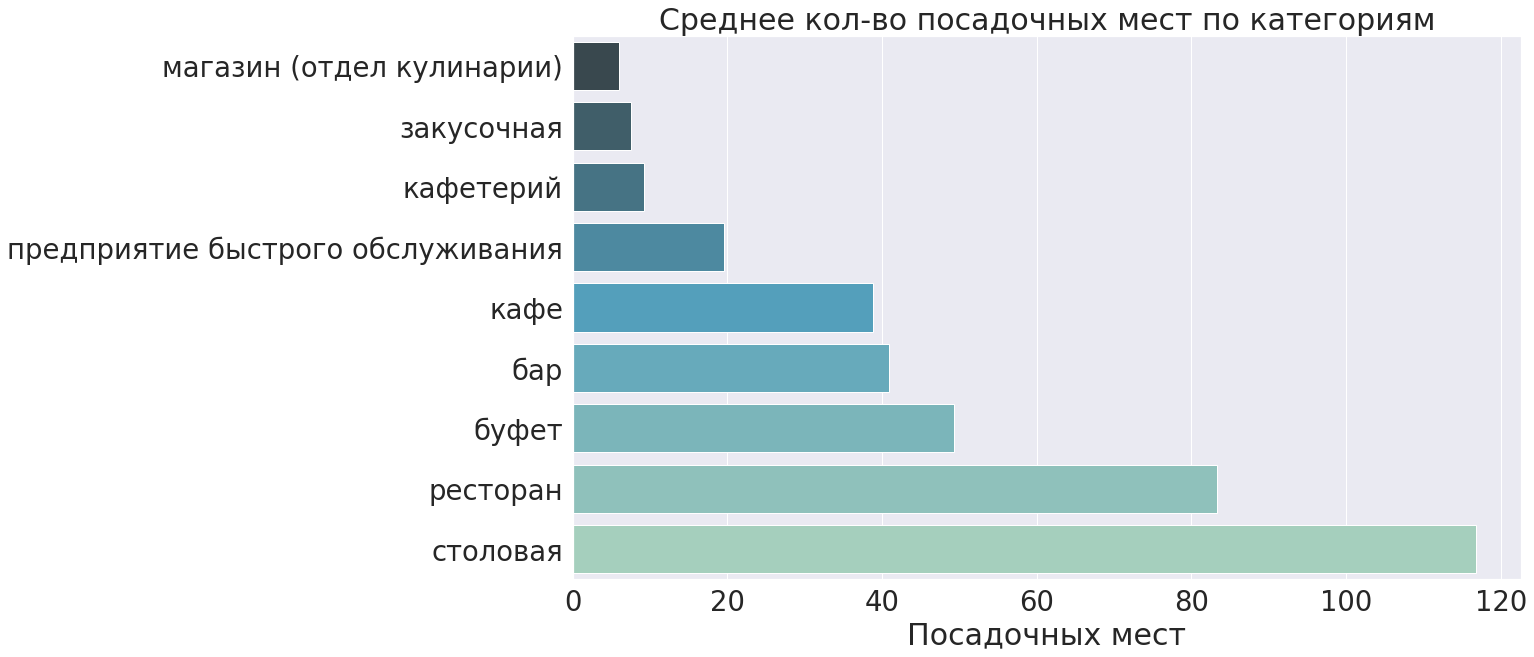

In [27]:
result = moscow_rest.groupby(
    'object_type')['number'].mean().reset_index().sort_values('number')

plt.figure(figsize = (17,10))
sns.set(font_scale=2.5)
sns.set_style('darkgrid')
sns.barplot(y = 'object_type', 
            x = 'number', 
            data = moscow_rest, 
            ci = None,
            order = result['object_type'],
            palette = 'GnBu_d'
           )
plt.ylabel('')
plt.xlabel('Посадочных мест');
plt.title('Среднее кол-во посадочных мест по категориям');

Лидирующие позиции занимают предприятия массового питания - столовые. В среднем около 120 посадочных мест. Ниже расположились рестораны - в среднем порядка 80 посадочных мест, далее буфеты и бары.
Среднее число мест в кафе - около 40. Ранее для сетевых кафе было определено такое же медианное количество посадочных мест. Очевидно, что это является характеристикой кафе имеено как вида предприятия общественного питания.
Предприятия быстрого обслуживания имеют в среднем около 20 мест.
Замыкают список кафетерии, закусочные и отделы кулинарии - в среднем не более 7-10 посадочных мест.

### 10 улиц с самым большим количеством заведений

In [28]:
top10_streets = moscow_rest.query('street != "поселение Сосенское"').groupby(
    'street')['id'].count().sort_values(ascending = False).reset_index().head(10)

top10_streets.columns = ['street','rest_number']

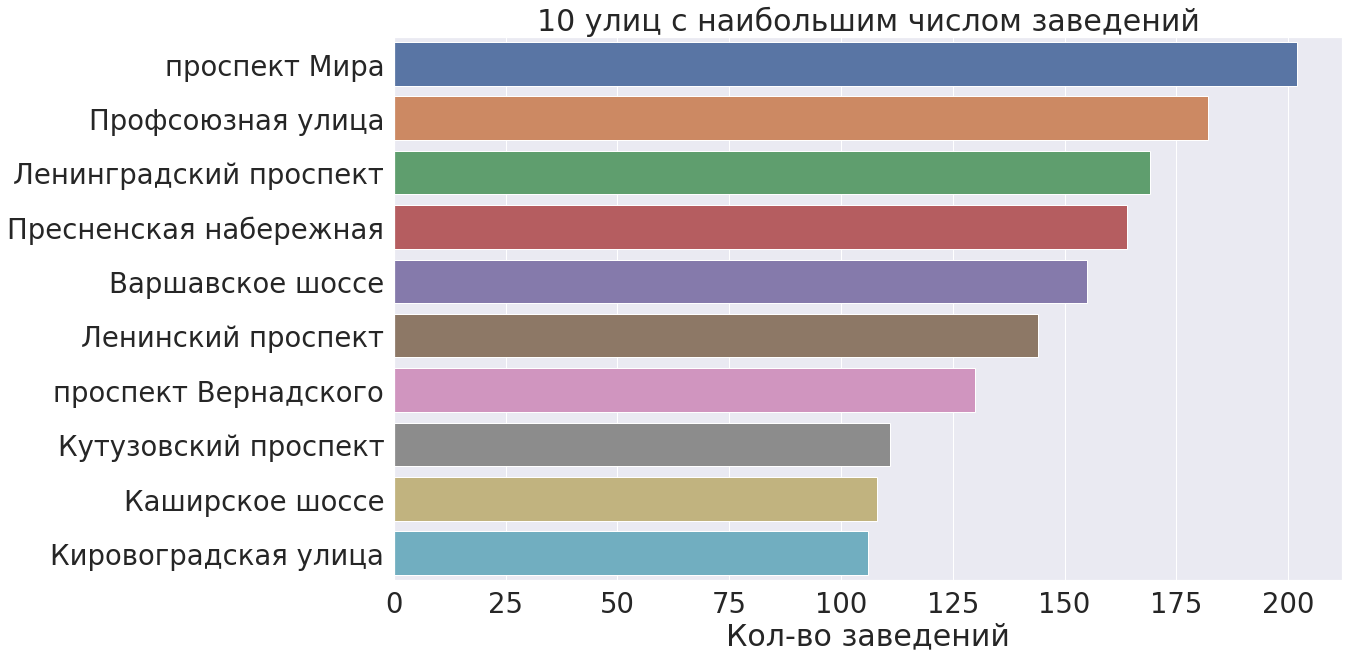

In [29]:
plt.figure(figsize = (17,10))
sns.set(font_scale=2.5)
sns.barplot(
    y = 'street', 
    x = 'rest_number', 
    data = top10_streets)
plt.ylabel('')
plt.xlabel('Кол-во заведений');
plt.title('10 улиц с наибольшим числом заведений');

Улицы из списка, за исключением Пресненской набережной и Кировградской улицы характреизуются общими чертами:
- являются радиальными по отношению к московским кольцам и связывают их;
- отличаются большой протяженностью;
- это улицы-магистрали с большим числом полос

Пресненская набережная являющется относительно короткой улочкой около Moscow City. Кировградская улица располагается в Чертаново и, по сути, тупиковая.

#### Районы улиц из списка Топ-10 с большим количество заведений

In [30]:
# районы с высокой плотностью заведений общественного питания
districts_high_density = moscow_rest[moscow_rest['street'].isin(top10_streets['street'])].groupby(
    'district',as_index = False)['id'].count().sort_values(
                                                by = 'id', ascending = False).reset_index(
                                                                                drop = True)
districts_high_density.columns = ['district','org_number']
districts_high_density.head(10)

,district,org_number
0,Пресненский район,164
1,район Чертаново Центральное,90
2,район Тропарёво-Никулино,84
3,район Аэропорт,65
4,Обручевский район,64
5,Мещанский район,63
6,район Свиблово,62
7,район Дорогомилово,58
8,район Нагатино-Садовники,55
9,район Фили-Давыдково,53


Улицы из списка ТОП-10 достаточно протяженные и захватывают несколько районов. Среди них есть и районы центрального округа, и южного, и западного. Представлены и близкие к центру районы, и находящиеся вблизи МКАД
### Улицы с одним объектом общественного питания

In [31]:
one_org_street = moscow_rest.groupby('street', as_index = False)['id'].count().query('id == 1')
print('Количество улиц с одним заведением общественного питания: {0}'.format(
    one_org_street['street'].count()))

Количество улиц с одним заведением общественного питания: 544


In [32]:
districts_low_density = moscow_rest[moscow_rest['street'].isin(one_org_street['street'])].groupby(
    'district', as_index = False)['id'].count().sort_values(
                                                by = 'id', ascending = False).reset_index(
                                                                                drop = True)
districts_low_density.columns = ['district','org_number']
districts_low_density.head()

,district,org_number
0,Таганский район,28
1,район Хамовники,27
2,Басманный район,22
3,Тверской район,21
4,Пресненский район,19


Районы в центре Москвы включают в себя как улицы с большим количеством заведений, так и улицы лишь с одним. Определим непересекающиеся в списках районы с высокой и низкой плотностью заведений на их улицах.  

In [33]:
districts_low_density[~districts_low_density['district'].isin(
    districts_high_density['district'])].head(6)

,district,org_number
0,Таганский район,28
1,район Хамовники,27
2,Басманный район,22
3,Тверской район,21
5,район Марьина Роща,17
6,район Сокольники,15


Целесообразно рассмотреть возможность размещения нового заведения в этих районах

### Распределение количества посадочных мест на улицах с высокой плотностью заведений

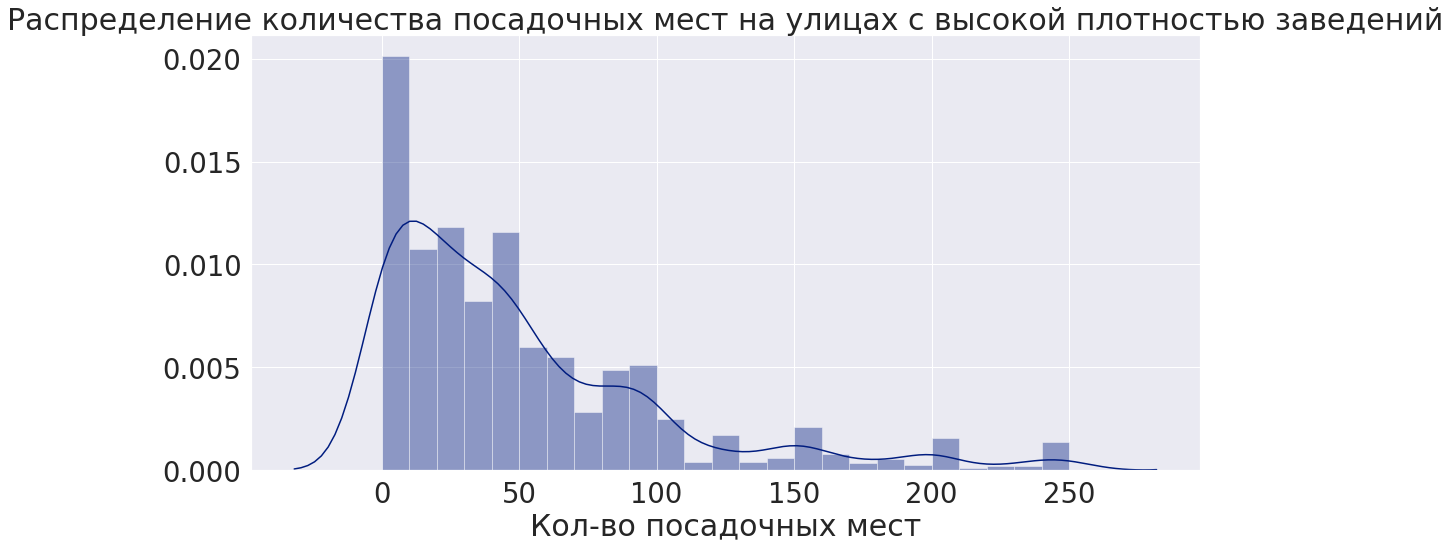

In [34]:
plt.figure(figsize=(17,8))
sns.set(font_scale=2.5)
sns.set_palette('dark')
sns.distplot(moscow_rest[
    moscow_rest['street'].isin(top10_streets['street'])]['number'])
plt.xlabel('Кол-во посадочных мест');
plt.title('Распределение количества посадочных мест на улицах с высокой плотностью заведений');

График содержит в себе характерные черты, выявленные ранее в графиках распределения количества посадочных мест в кафе и предприятиях быстрого обслуживания. Заметен также пик в районе 80-100 мест, характерный для ресторанов и столовых.

In [35]:
moscow_rest[
    moscow_rest['street'].isin(top10_streets['street'])]['number'].describe()

count    1471.000000
mean       50.070020
std        52.033269
min         0.000000
25%        12.000000
50%        36.000000
75%        70.000000
max       250.000000
Name: number, dtype: float64

### Выводы
1. Наиболее устойчивой формой предприятий общественного питания на рынке является форма кафе;
2. Кафе в основном являются отдельными предприятиям, лишь треть заведений принадлежат сетям;
3. Среднее и медианное количество посадочных мест в кафе в целом и в сетевых кафе примерно одинаковое - около 40. Заведения подобного формата с ростом количества мест встречаются реже и реже;
4. Улицы с высокой плотностью заведений общественного питания в большинстве случаев - радиальные шоссе или магистральные улицы, связывающие окраины Москвы с центром. 

Робокафе по формату должно быть именно кафе, с числом посадочных мест 30-40. Формат кафе потенциально пригоден для формирования сети заведений. Рекомендуется рассмотреть в первую очередь районы:
- Таганский,
- Хамовники,
- Басманный,
- Тверской,
- Марьина Роща,
- Сокольники.

Эти районы являются центральными и в то же время отдалены от магистральных улиц с высокой плотностью заведений общественного питания. В период выхода на рынок для уникального заведения требуется сохранять дистанцию от массовых предприятий.  